In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

df = pd.read_csv('cleaned/cleaned_data.csv')

Mean of TradeValue: 181161.76987179488


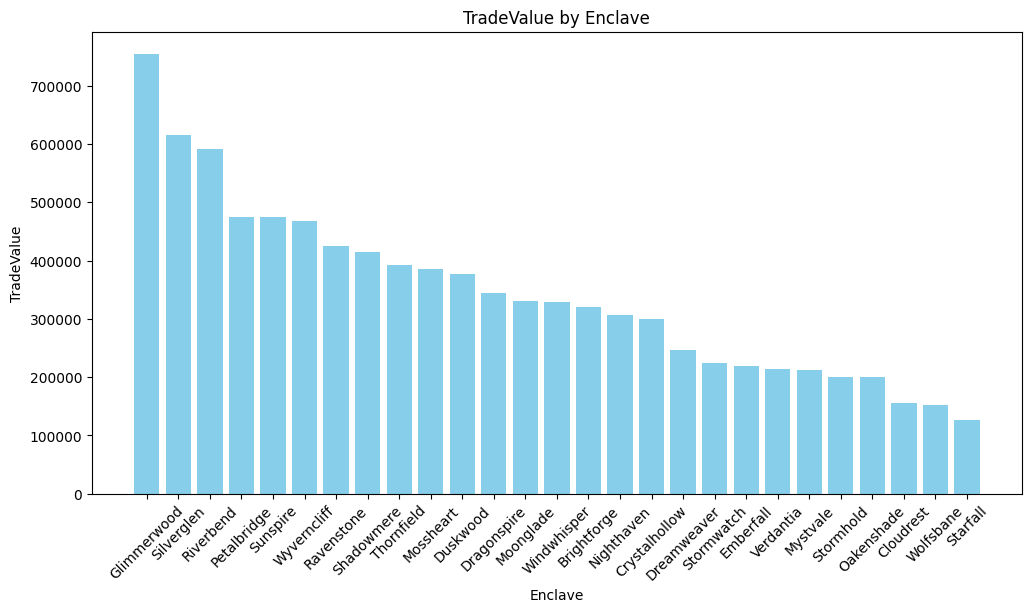

In [14]:
# Calculate the mean of the 'TradeValue' column
trade_value_mean = df['TradeValue'].mean()
print(f"Mean of TradeValue: {trade_value_mean}")

# Sort the 'TradeValue' column
sorted_trade_values = df.sort_values(by='TradeValue', ascending=False)

x = sorted_trade_values['Enclave']
y = sorted_trade_values['TradeValue']

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='skyblue')
plt.xlabel('Enclave')
plt.ylabel('TradeValue')
plt.title('TradeValue by Enclave')
plt.xticks(rotation=45)
plt.show()

<h1> Step 1: Define Constants

In [15]:
# Annual Income = $30,000
# Monthly Income = $30,000 / 12 = $2,500
# Affordability Threshold = 30% of $2,500 = $750 per month
# Loan Parameters:
#     Downpayment = 20% of TradeValue
#     Loan Amount = TradeValue - Downpayment
#     Interest Rate = 4% annually → 0.00333 monthly
#     Loan Term = 30 years (360 payments)


# Constants
Monthly_income = 2500
Affordability_threshold = 0.3 * Monthly_income  # 30% of monthly income
Interest_rate = 0.04 / 12  # 4% annual → monthly rate
Loan_term = 30 * 12  # 30 years * 12 months

# Function to calculate loans
def calculate_loans(row):
    Downpayment = 0.2 * row['TradeValue']
    Loan_amount = row['TradeValue'] - Downpayment
    return pd.Series([Downpayment, Loan_amount], index=['Downpayment', 'LoanAmount'])

df[['Downpayment', 'LoanAmount']] = df.apply(calculate_loans, axis=1)

# Monthly Payment Calculation
def calculate_monthly_payments(row):
    monthly_payment = (row['LoanAmount'] * Interest_rate * (1 + Interest_rate) ** Loan_term) / ((1 + Interest_rate) ** Loan_term - 1)
    return monthly_payment

df['MonthlyPayment'] = df.apply(calculate_monthly_payments, axis=1)

# Affordability Check
def check_affordability(row):
    return 1 if row['MonthlyPayment'] <= Affordability_threshold else 0

df['AffordableDwelling'] = df.apply(check_affordability, axis=1)

print(df)

# Step: Define the folder path and file path
folder_path = "cleaned"
file_path = os.path.join(folder_path, "cleaned_data.csv")

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)

# Confirm that the dataset has been saved successfully
print(f"✅ The cleaned dataset has been saved to '{file_path}'.")

df.describe(include='O')


        DI  TradeValue     RealmType        Enclave  LivingQuarters  \
0        0    269500.0   Meadowlands    Brightforge          2143.0   
1        1    184900.0   Meadowlands    Brightforge           923.0   
2        2     87000.0  GnomeBurough    Petalbridge           959.0   
3        3    130000.0   Meadowlands     Shadowmere           798.0   
4        4    144000.0   Meadowlands    Dragonspire          1172.0   
...    ...         ...           ...            ...             ...   
2335  2335    146000.0   Meadowlands  Crystalhollow           839.0   
2336  2336     88250.0  GnomeBurough      Wolfsbane           839.0   
2337  2337    182000.0   AetherIsles    Wyverncliff          1098.0   
2338  2338    128000.0   Meadowlands     Shadowmere           901.0   
2339  2339     85000.0  GnomeBurough       Mystvale          1173.0   

      ParcelSize ParcelSizeUnit  StructuralIntegrity ExteriorCharm  \
0         7939.0           sqft                    5        Common   
1      

,RealmType,Enclave,ParcelSizeUnit,ExteriorCharm
count,2340,2340,2340,2340
unique,3,27,1,4
top,Meadowlands,Dragonspire,sqft,Common
freq,1776,353,2340,1431


<h2> Simple Classification Model

<h3>Visualizing the Data</h3>
we can decide between certain rules in our classification model. For example, we can use the following rules:
<ul>
    <li>If a certain enclave has only unaffordable dwellings, then we can classify all the dwellings in that enclave as unaffordable.</li>
    <li>If a certain enclave has only affordable dwellings, then we can classify all the dwellings in that enclave as affordable.</li>
    <li>If a certain enclave has a mix of affordable and unaffordable dwellings, then we can classify each dwelling based on the affordability threshold.</li>
</ul>

Affordability by Enclave (sorted by percentage):
               Percent_Affordable  Total_Properties
Enclave                                            
Wolfsbane                1.000000                30
Starfall                 1.000000                25
Cloudrest                1.000000                18
Emberfall                0.991525               118
Mystvale                 0.972222                72
Petalbridge              0.963351               191
Dragonspire              0.957507               353
Stormwatch               0.954545                88
Stormhold                0.950000                40
Shadowmere               0.917197               157
Oakenshade               0.888889                 9
Crystalhollow            0.808989                89
Duskwood                 0.780303               132
Dreamweaver              0.695652                23
Brightforge              0.690000               100
Verdantia                0.666667                 6
Nighthaven     

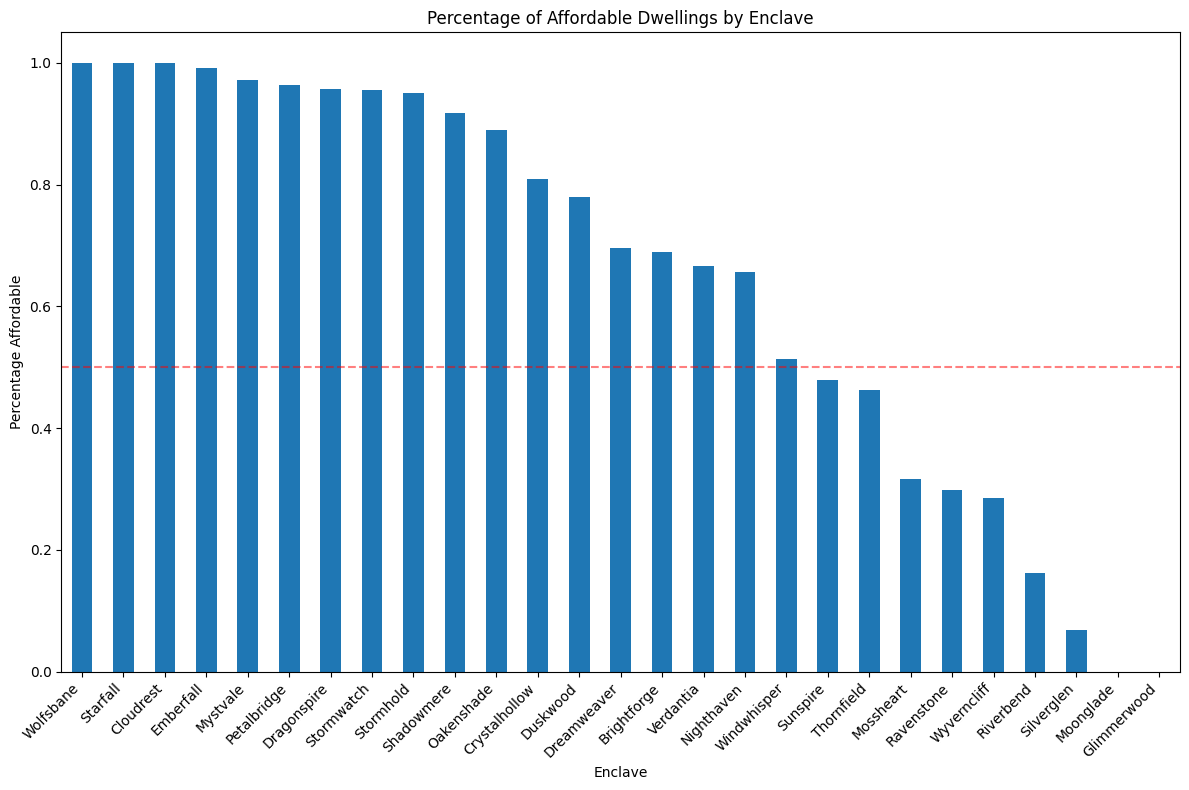

In [16]:
# Group by Enclave and calculate percentage of affordable dwellings
enclave_affordability = df.groupby('Enclave')['AffordableDwelling'].agg(['mean', 'count'])
enclave_affordability.columns = ['Percent_Affordable', 'Total_Properties']
enclave_affordability = enclave_affordability.sort_values('Percent_Affordable', ascending=False)

# Display results
print("Affordability by Enclave (sorted by percentage):")
print(enclave_affordability)

# Plot the results
plt.figure(figsize=(12, 8))
enclave_affordability['Percent_Affordable'].plot(kind='bar')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.title('Percentage of Affordable Dwellings by Enclave')
plt.xlabel('Enclave')
plt.ylabel('Percentage Affordable')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h3> In this output you see that certain enclaves have a low affordability rate </h3>
For our simple rule in our benchmark model we state that these enclaves are "premium", and automaticly unaffordable.